In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/windows-malwares/PE_Section.csv
/kaggle/input/windows-malwares/DLLs_Imported.csv
/kaggle/input/windows-malwares/API_Functions.csv
/kaggle/input/windows-malwares/PE_Header.csv


# Data Engineering

In [55]:
# Paths to the four CSVs from above
p_dlls   = "/kaggle/input/windows-malwares/DLLs_Imported.csv"
p_api    = "/kaggle/input/windows-malwares/API_Functions.csv"
p_hdr    = "/kaggle/input/windows-malwares/PE_Header.csv"
p_sect   = "/kaggle/input/windows-malwares/PE_Section.csv"

## Check Binary/Continuous Features for Each Dataset

In [56]:
# Helper: read CSV and lower-case/normalize column names
def read_norm(path):
    df = pd.read_csv(path, low_memory=False)
    df.columns = [c.strip().lower() for c in df.columns]
    return df

dlls  = read_norm(p_dlls)
api   = read_norm(p_api)
hdr   = read_norm(p_hdr)
sect  = read_norm(p_sect)

In [57]:
def column_type_summary(df, name):
    binary_cols = []
    continuous_cols = []

    for col in df.columns:
        if col.lower() in ['sha256', 'type']:
            continue
        vals = df[col].dropna().unique()
        if set(vals).issubset({0, 1}):
            binary_cols.append(col)
        else:
            continuous_cols.append(col)

    print(f"--- {name} ---")
    print(f"Rows:               {len(df):>7,}")
    print(f"Binary columns:     {len(binary_cols):>7}")
    print(f"Continuous columns: {len(continuous_cols):>7}")
    print(f"Total feature cols: {len(df.columns) - 2:>7}")  # excluding sha256 + type
    print(f"Total columns:      {len(df.columns):>7}\n")

    return binary_cols, continuous_cols

# Binary Datasets
dlls_bin, dlls_cont = column_type_summary(dlls, "p_dlls")
api_bin, api_cont   = column_type_summary(api,  "p_api")

# Continuous Datasets
hdr_bin, hdr_cont   = column_type_summary(hdr,  "p_hdr")
sect_bin, sect_cont = column_type_summary(sect, "p_sect")


--- p_dlls ---
Rows:                29,498
Binary columns:         629
Continuous columns:       0
Total feature cols:     629
Total columns:          631

--- p_api ---
Rows:                29,505
Binary columns:       21918
Continuous columns:       0
Total feature cols:   21918
Total columns:        21920

--- p_hdr ---
Rows:                29,807
Binary columns:           1
Continuous columns:      51
Total feature cols:      52
Total columns:           54

--- p_sect ---
Rows:                29,760
Binary columns:           8
Continuous columns:      82
Total feature cols:      90
Total columns:           92



## Merge Respective Binary/Continuous Datasets (Binary: APIs + DLLs | Continuous: PE_Header + PE_Sections)

In [58]:
# Ensure the join key is present and normalized
for df in [dlls, api, hdr, sect]:
    assert 'sha256' in df.columns, f"'sha256' not found in {df.shape}"

# (Optional) cast 0/1 feature columns to smaller ints to save RAM
def cast_binary(df):
    for c in df.columns:
        if c not in ('sha256', 'type'):
            # Try to downcast to uint8 if it looks like binary
            if df[c].dropna().isin([0,1]).all():
                df[c] = df[c].astype('uint8')
    return df

dlls = cast_binary(dlls)
api  = cast_binary(api)
# hdr/sect are numeric counts/sizes; let pandas infer first (or downcast later)

In [59]:
from functools import reduce

# Keep 'type' only once; check for mismatches first.
def label_map(df):
    return df[['sha256', 'type']].drop_duplicates()

### Binary: (APIs + DLLs)

In [60]:
lbls = [label_map(x).rename(columns={'type': f"type_{i}"}) for i, x in enumerate([dlls, api])]
lbl_chk = reduce(lambda l, r: l.merge(r, on='sha256', how='outer'), lbls)

# If all labels match per sha256, each row should have identical values across type_* columns
mismatch = lbl_chk.drop(columns=['sha256']).nunique(axis=1) > 1
print("Label mismatches:", mismatch.sum())
# If mismatches==0, we can safely keep one 'type' column later.

Label mismatches: 0


In [61]:
binary_df = dlls.merge(api, on=['sha256', 'type'], how='inner')

# drop duplicate columns
dupe_cols = [c for c in binary_df.columns if c.startswith('type') and c != 'type']
binary_df.drop(columns=dupe_cols, inplace=True, errors='ignore')

print(binary_df.shape)

(29502, 22533)


### Continuous: (PE Header + PE Sections)

In [62]:
lbls = [label_map(x).rename(columns={'type': f"type_{i}"}) for i, x in enumerate([hdr, sect])]
lbl_chk = reduce(lambda l, r: l.merge(r, on='sha256', how='outer'), lbls)

# If all labels match per sha256, each row should have identical values across type_* columns
mismatch = lbl_chk.drop(columns=['sha256']).nunique(axis=1) > 1
print("Label mismatches:", mismatch.sum())
# If mismatches==0, we can safely keep one 'type' column later.

Label mismatches: 0


In [63]:
cont_df = hdr.merge(sect, on=['sha256', 'type'], how='inner')

# drop duplicate columns
dupe_cols = [c for c in cont_df.columns if c.startswith('type') and c != 'type']
cont_df.drop(columns=dupe_cols, inplace=True, errors='ignore')

print(cont_df.shape)

(29514, 144)


## Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

bin_X_all = binary_df.drop(['sha256', 'type'], axis=1)
bin_Y_all = binary_df['type'].apply(lambda v: 0 if v == 0 else 1)
bin_correlations = bin_X_all.corrwith(bin_Y_all)
bin_correlations_abs = bin_correlations.abs()
top15 = bin_correlations_abs.sort_values(ascending=False).head(15).index.tolist()
print("Top 15 Features:", top15)
print("\n")

bin_X = binary_df[top15]
bin_Y = binary_df['type'].apply(lambda v: 0 if v == 0 else 1)

bin_X_trainval, bin_X_test, bin_Y_trainval, bin_Y_test = train_test_split(
    bin_X, bin_Y, test_size=0.15, random_state=42, stratify=bin_Y
)
val_fraction = 0.15 / 0.85
bin_X_train, bin_X_val, bin_Y_train, bin_Y_val = train_test_split(
    bin_X_trainval, bin_Y_trainval, test_size=val_fraction, random_state=42, stratify=bin_Y_trainval
)
print("Training set:", bin_X_train.shape)
print("Validation set:", bin_X_val.shape)
print("Test set:", bin_X_test.shape)


bin_clf = LogisticRegression(
    solver='liblinear',
    penalty='l1',
    max_iter=500,
    class_weight='balanced',
    random_state=42
)
bin_clf.fit(bin_X_train, bin_Y_train)

Top 15 Features: ['cspecifichandler', 'rtllookupfunctionentry', 'rtlvirtualunwind', 'fmode', 'rtlcapturecontext', 'iobfunc', 'free', 'malloc', 'amsgexit', 'cexit', 'lock', 'unlock', 'rtladdfunctiontable', 'fprintf', 'calloc']


Training set: (20650, 15)
Validation set: (4426, 15)
Test set: (4426, 15)


LogisticRegression(class_weight='balanced', max_iter=500, penalty='l1',
                   random_state=42, solver='liblinear')

In [65]:
print("Training accuracy: {:.2f}%".format(bin_clf.score(bin_X_train, bin_Y_train)*100))
print("Validation accuracy: {:.2f}%".format(bin_clf.score(bin_X_val, bin_Y_val)*100))
print("Test accuracy: {:.2f}%".format(bin_clf.score(bin_X_test, bin_Y_test)*100))

Training accuracy: 93.41%
Validation accuracy: 93.83%
Test accuracy: 93.47%


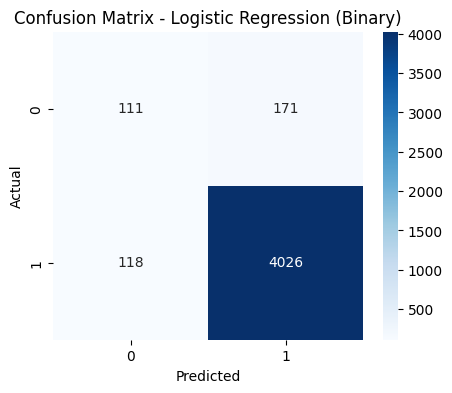

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as bin_sns
import matplotlib.pyplot as bin_plt

bin_Y_pred = bin_clf.predict(bin_X_test)
bin_cm = confusion_matrix(bin_Y_test, bin_Y_pred)
bin_plt.figure(figsize=(5,4))
bin_sns.heatmap(bin_cm, annot=True, fmt="d", cmap="Blues")
bin_plt.title("Confusion Matrix - Logistic Regression (Binary)")
bin_plt.xlabel("Predicted")
bin_plt.ylabel("Actual")
bin_plt.show()

In [67]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(bin_Y_test, bin_Y_pred))
print("\nClassification Report:\n")
print(classification_report(bin_Y_test, bin_Y_pred))

Accuracy: 0.9347040216900135

Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.39      0.43       282
           1       0.96      0.97      0.97      4144

    accuracy                           0.93      4426
   macro avg       0.72      0.68      0.70      4426
weighted avg       0.93      0.93      0.93      4426



In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cont_X = cont_df.drop(['sha256', 'type'], axis=1)
cont_Y = cont_df['type'].apply(lambda v: 0 if v == 0 else 1)

cont_X_trainval, cont_X_test, cont_Y_trainval, cont_Y_test = train_test_split(
    cont_X, cont_Y, test_size=0.15, random_state=42, stratify=cont_Y
)
val_fraction = 0.15 / 0.85
cont_X_train, cont_X_val, cont_Y_train, cont_Y_val = train_test_split(
    cont_X_trainval, cont_Y_trainval, test_size=val_fraction, random_state=42, stratify=cont_Y_trainval
)

cont_scaler = StandardScaler()
cont_X_train_scaled = cont_scaler.fit_transform(cont_X_train)
cont_X_val_scaled = cont_scaler.transform(cont_X_val)
cont_X_test_scaled = cont_scaler.transform(cont_X_test)

pca = PCA(n_components=0.95)
cont_X_train_pca = pca.fit_transform(cont_X_train_scaled)
cont_X_val_pca = pca.transform(cont_X_val_scaled)
cont_X_test_pca = pca.transform(cont_X_test_scaled)

print("Original feature count:", cont_X_train.shape[1])
print("Reduced feature count with PCA:", cont_X_train_pca.shape[1])
print("\n")

print("Training set:", cont_X_train_pca.shape)
print("Validation set:", cont_X_val_pca.shape)
print("Test set:", cont_X_test_pca.shape)

cont_clf = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    max_iter=2000,
    class_weight='balanced',
    random_state=42
)
cont_clf.fit(cont_X_train_pca, cont_Y_train)

Original feature count: 142
Reduced feature count with PCA: 55


Training set: (20659, 55)
Validation set: (4427, 55)
Test set: (4428, 55)


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42,
                   solver='liblinear')

In [69]:
print("Training accuracy: {:.2f}%".format(cont_clf.score(cont_X_train_pca, cont_Y_train)*100))
print("Validation accuracy: {:.2f}%".format(cont_clf.score(cont_X_val_pca, cont_Y_val)*100))
print("Test accuracy: {:.2f}%".format(cont_clf.score(cont_X_test_pca, cont_Y_test)*100))

Training accuracy: 86.52%
Validation accuracy: 87.08%
Test accuracy: 86.74%


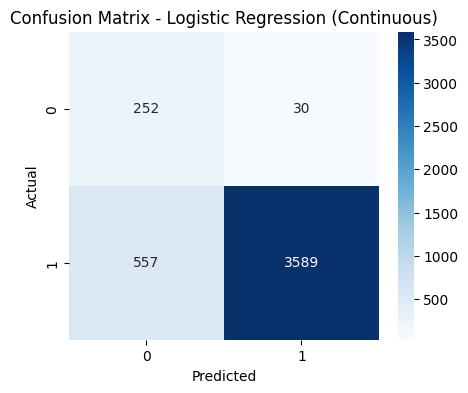

In [70]:
import seaborn as cont_sns
import matplotlib.pyplot as cont_plt

cont_Y_pred = cont_clf.predict(cont_X_test_pca)
cont_cm = confusion_matrix(cont_Y_test, cont_Y_pred)
cont_plt.figure(figsize=(5,4))
cont_sns.heatmap(cont_cm, annot=True, fmt="d", cmap="Blues")
cont_plt.title("Confusion Matrix - Logistic Regression (Continuous)")
cont_plt.xlabel("Predicted")
cont_plt.ylabel("Actual")
cont_plt.show()

In [71]:
print("Accuracy:", accuracy_score(cont_Y_test, cont_Y_pred))
print("\nClassification Report:\n")
print(classification_report(cont_Y_test, cont_Y_pred))

Accuracy: 0.8674345076784101

Classification Report:

              precision    recall  f1-score   support

           0       0.31      0.89      0.46       282
           1       0.99      0.87      0.92      4146

    accuracy                           0.87      4428
   macro avg       0.65      0.88      0.69      4428
weighted avg       0.95      0.87      0.89      4428



# SVM

In [72]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## SVM - Binary Features 

### Training + Test sets

In [73]:
bin_X_train_full, bin_X_test, bin_Y_train_full, bin_Y_test = train_test_split(
    bin_X, bin_Y, test_size=0.2, stratify=bin_Y, random_state=42
)

# separate validation set if necessary 
val_fraction = 0.2 / 0.8
bin_X_train, bin_X_val, bin_Y_train, bin_Y_val = train_test_split(
    bin_X_train_full, bin_Y_train_full, test_size=val_fraction, stratify=bin_Y_train_full, random_state=42
)

### Scale Binary Features 

In [74]:
binary_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(class_weight="balanced", probability=True, random_state=42))
])

### Hyperparameter Search Space 

In [75]:
binary_params = {
    "svm__C": [0.1, 1, 3, 10],
    "svm__gamma": ["scale", 0.01, 0.001],
    "svm__kernel": ["rbf"]
}

binary_search = GridSearchCV(
    binary_pipeline,
    binary_params,
    scoring="f1_macro", 
    cv=3,
    n_jobs=-1,
    verbose=1
)

### Train Binary SVM 

In [76]:
binary_search.fit(bin_X_train, bin_Y_train)
print("Best params (binary SVM):", binary_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params (binary SVM): {'svm__C': 3, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


### Prediction and Evaluation

In [77]:
bin_y_pred = binary_search.predict(bin_X_test)

print("Binary SVM Performance:")
print("Accuracy:", accuracy_score(bin_Y_test, bin_y_pred))
print(classification_report(bin_Y_test, bin_y_pred, zero_division=0))

Binary SVM Performance:
Accuracy: 0.9540755804101
              precision    recall  f1-score   support

           0       0.77      0.39      0.52       375
           1       0.96      0.99      0.98      5526

    accuracy                           0.95      5901
   macro avg       0.87      0.69      0.75      5901
weighted avg       0.95      0.95      0.95      5901



### Confusion Matrix 

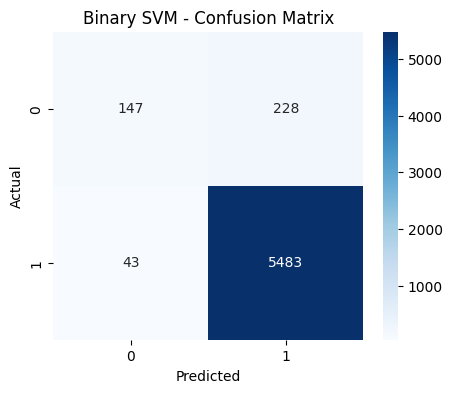

In [78]:
bin_cm = confusion_matrix(bin_Y_test, bin_y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(bin_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Binary SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### ROC Curve 

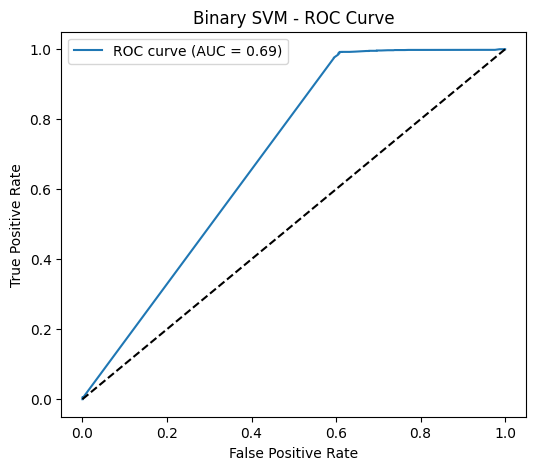

In [79]:
bin_y_proba = binary_search.predict_proba(bin_X_test)[:,1]  # probability for class 1
bin_fpr, bin_tpr, bin_thresh = roc_curve(bin_Y_test, bin_y_proba)
bin_auc = roc_auc_score(bin_Y_test, bin_y_proba)

plt.figure(figsize=(6,5))
plt.plot(bin_fpr, bin_tpr, label=f"ROC curve (AUC = {bin_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.title("Binary SVM - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## SVM - Continuous Features

### Training + Test Sets 

In [80]:
cont_X_train_full, cont_X_test, cont_Y_train_full, cont_Y_test = train_test_split(
    cont_X, cont_Y, test_size=0.2, stratify=cont_Y, random_state=42
)
val_fraction = 0.2 / 0.8
cont_X_train, cont_X_val, cont_Y_train, cont_Y_val = train_test_split(
    cont_X_train_full, cont_Y_train_full, test_size=val_fraction, stratify=cont_Y_train_full, random_state=42
)

### Scaling and PCA 

In [81]:
# normalizes features, 95% variance for PCA 
cont_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("svm", SVC(class_weight="balanced", probability=True, random_state=42))
])

### Hyperparameter Search 

In [82]:
cont_params = {
    "svm__C": [0.5, 1, 5],
    "svm__gamma": ["scale", 0.01],
    "svm__kernel": ["rbf"]
}

cont_search = GridSearchCV(
    cont_pipeline,
    cont_params,
    scoring="f1_macro",  # focus on both classes
    cv=3,
    n_jobs=-1,
    verbose=1
)

### Train Continuous SVM 

In [83]:
cont_search.fit(cont_X_train, cont_Y_train)
print("Best params (continuous SVM):", cont_search.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params (continuous SVM): {'svm__C': 5, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


### Prediction and Evaluation 

In [84]:
cont_y_pred = cont_search.predict(cont_X_test)

print("Continuous SVM Performance:")
print("Accuracy:", accuracy_score(cont_Y_test, cont_y_pred))
print(classification_report(cont_Y_test, cont_y_pred, zero_division=0))

Continuous SVM Performance:
Accuracy: 0.9564628155175334
              precision    recall  f1-score   support

           0       0.60      0.91      0.73       375
           1       0.99      0.96      0.98      5528

    accuracy                           0.96      5903
   macro avg       0.80      0.94      0.85      5903
weighted avg       0.97      0.96      0.96      5903



### Confusion Matrix 

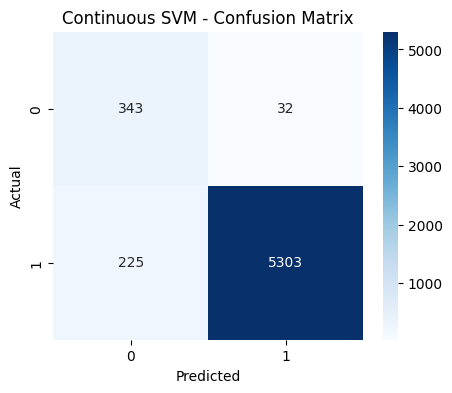

In [85]:
cont_cm = confusion_matrix(cont_Y_test, cont_y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cont_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Continuous SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### ROC Curve

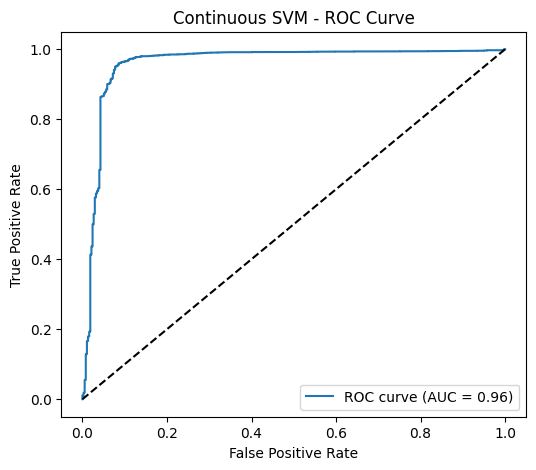

In [86]:
cont_y_proba = cont_search.predict_proba(cont_X_test)[:,1]  # probability for class 1
cont_fpr, cont_tpr, cont_thresh = roc_curve(cont_Y_test, cont_y_proba)
cont_auc = roc_auc_score(cont_Y_test, cont_y_proba)

plt.figure(figsize=(6,5))
plt.plot(cont_fpr, cont_tpr, label=f"ROC curve (AUC = {cont_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.title("Continuous SVM - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## SVM - Ensemble (Binary + Continuous)

### Merge binary and continuous test sets by SHA256

In [87]:
bin_test_df = bin_X_test.copy()
bin_test_df['y_true'] = bin_Y_test
bin_test_df['bin_proba'] = bin_y_proba
bin_test_df['sha256'] = binary_df.loc[bin_X_test.index, 'sha256'].values

cont_test_df = cont_X_test.copy()
cont_test_df['y_true'] = cont_Y_test
cont_test_df['cont_proba'] = cont_y_proba
cont_test_df['sha256'] = cont_df.loc[cont_X_test.index, 'sha256'].values

# Inner merge on sha256 and true label to align probabilities
merged_test = bin_test_df.merge(
    cont_test_df[['sha256', 'cont_proba', 'y_true']],
    on=['sha256', 'y_true'],
    how='inner'
)

### Ensemble Predictions with average probabilities 

In [88]:
ensemble_proba = (merged_test['bin_proba'] + merged_test['cont_proba']) / 2
ensemble_pred = (ensemble_proba >= 0.5).astype(int)
ensemble_y = merged_test['y_true']

### Accuracy and Classification Report

In [89]:
print("Ensemble SVM Performance:")
print("Accuracy:", accuracy_score(ensemble_y, ensemble_pred))
print(classification_report(ensemble_y, ensemble_pred, zero_division=0))

Ensemble SVM Performance:
Accuracy: 0.979718116191131
              precision    recall  f1-score   support

           0       0.82      0.46      0.59        92
           1       0.98      1.00      0.99      2817

    accuracy                           0.98      2909
   macro avg       0.90      0.73      0.79      2909
weighted avg       0.98      0.98      0.98      2909



### Confusion Matrix 

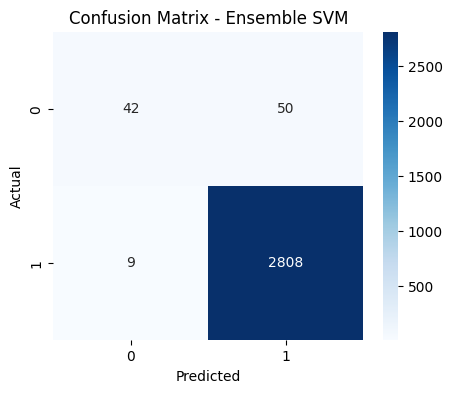

In [90]:
cm = confusion_matrix(ensemble_y, ensemble_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Ensemble SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### ROC 

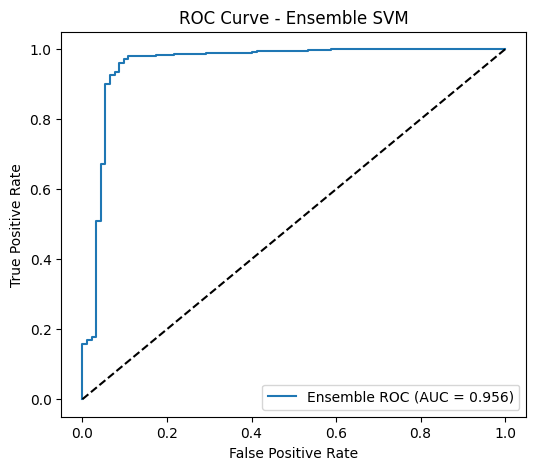

In [91]:
fpr, tpr, thresholds = roc_curve(ensemble_y, ensemble_proba)
roc_auc = roc_auc_score(ensemble_y, ensemble_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Ensemble ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Ensemble SVM")
plt.legend(loc="lower right")
plt.show()

# XGBoost

In [93]:
from xgboost import XGBClassifier

## XGBoost - Binary Features

### Split Testing and Training

In [94]:
bin_X = binary_df[top15]  
bin_Y = binary_df['type'].apply(lambda v: 0 if v == 0 else 1)

bin_X_trainval, bin_X_test, bin_Y_trainval, bin_Y_test = train_test_split(
    bin_X, bin_Y, test_size=0.15, random_state=42, stratify=bin_Y
)
val_fraction = 0.15 / 0.85
bin_X_train, bin_X_val, bin_Y_train, bin_Y_val = train_test_split(
    bin_X_trainval, bin_Y_trainval, test_size=val_fraction, random_state=42, stratify=bin_Y_trainval
)

### Scale Features 

In [95]:
scaler_bin = StandardScaler()
bin_X_train_scaled = scaler_bin.fit_transform(bin_X_train)
bin_X_val_scaled   = scaler_bin.transform(bin_X_val)
bin_X_test_scaled  = scaler_bin.transform(bin_X_test)

### Training

In [98]:
xgb_bin = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(bin_Y_train) - sum(bin_Y_train)) / sum(bin_Y_train),  # handle imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_bin.fit(bin_X_train_scaled, bin_Y_train,
            eval_set=[(bin_X_val_scaled, bin_Y_val)],
            verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Prediction and Metrics 

In [99]:
bin_Y_pred = xgb_bin.predict(bin_X_test_scaled)
bin_Y_proba = xgb_bin.predict_proba(bin_X_test_scaled)[:,1]

print("Binary Feature XGBoost")
print("Accuracy:", accuracy_score(bin_Y_test, bin_Y_pred))
print(classification_report(bin_Y_test, bin_Y_pred, zero_division=0))

Binary Feature XGBoost
Accuracy: 0.9527790329868956
              precision    recall  f1-score   support

           0       0.76      0.38      0.51       282
           1       0.96      0.99      0.98      4144

    accuracy                           0.95      4426
   macro avg       0.86      0.69      0.74      4426
weighted avg       0.95      0.95      0.95      4426



### Confusion Matrix 

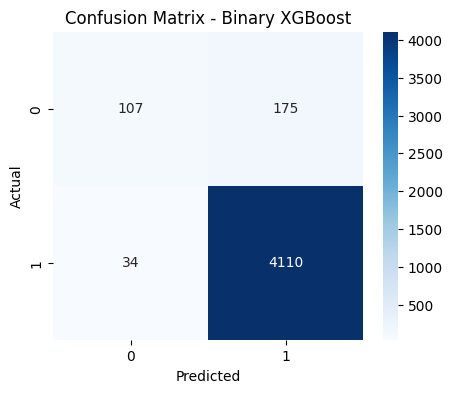

In [100]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(bin_Y_test, bin_Y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Binary XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### ROC Curve

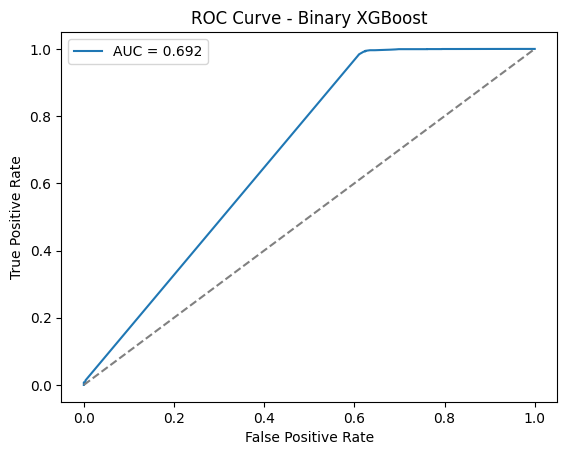

In [101]:
fpr, tpr, thresholds = roc_curve(bin_Y_test, bin_Y_proba)
auc_score = roc_auc_score(bin_Y_test, bin_Y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Binary XGBoost")
plt.legend()
plt.show()

## XGBoost - Continuous Features 

### Test Train Split

In [102]:
cont_X = cont_df.drop(['sha256','type'], axis=1)
cont_Y = cont_df['type'].apply(lambda v: 0 if v == 0 else 1)

cont_X_trainval, cont_X_test, cont_Y_trainval, cont_Y_test = train_test_split(
    cont_X, cont_Y, test_size=0.15, random_state=42, stratify=cont_Y
)
val_fraction = 0.15 / 0.85
cont_X_train, cont_X_val, cont_Y_train, cont_Y_val = train_test_split(
    cont_X_trainval, cont_Y_trainval, test_size=val_fraction, random_state=42, stratify=cont_Y_trainval
)

### Scaling and PCA 

In [103]:
scaler_cont = StandardScaler()
cont_X_train_scaled = scaler_cont.fit_transform(cont_X_train)
cont_X_val_scaled   = scaler_cont.transform(cont_X_val)
cont_X_test_scaled  = scaler_cont.transform(cont_X_test)

pca = PCA(n_components=0.95)
cont_X_train_pca = pca.fit_transform(cont_X_train_scaled)
cont_X_val_pca   = pca.transform(cont_X_val_scaled)
cont_X_test_pca  = pca.transform(cont_X_test_scaled)

### Train 

In [104]:
xgb_cont = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(cont_Y_train) - sum(cont_Y_train)) / sum(cont_Y_train),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_cont.fit(cont_X_train_pca, cont_Y_train,
             eval_set=[(cont_X_val_pca, cont_Y_val)],
             verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Prediction and Metrics 

In [105]:
cont_Y_pred = xgb_cont.predict(cont_X_test_pca)
cont_Y_proba = xgb_cont.predict_proba(cont_X_test_pca)[:,1]

print("Continuous Feature XGBoost")
print("Accuracy:", accuracy_score(cont_Y_test, cont_Y_pred))
print(classification_report(cont_Y_test, cont_Y_pred, zero_division=0))


Continuous Feature XGBoost
Accuracy: 0.9878048780487805
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       282
           1       0.99      0.99      0.99      4146

    accuracy                           0.99      4428
   macro avg       0.94      0.96      0.95      4428
weighted avg       0.99      0.99      0.99      4428



### Confusion Matrix

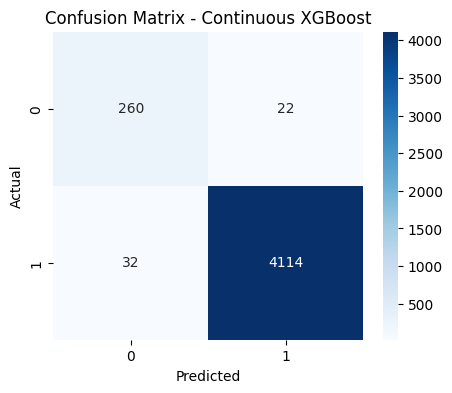

In [106]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(cont_Y_test, cont_Y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Continuous XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### ROC Curve

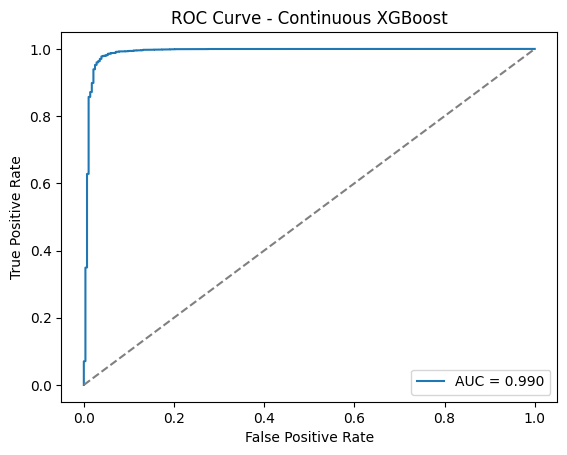

In [107]:
fpr, tpr, thresholds = roc_curve(cont_Y_test, cont_Y_proba)
auc_score = roc_auc_score(cont_Y_test, cont_Y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Continuous XGBoost")
plt.legend()
plt.show()

# Random Forest 

In [108]:
from sklearn.ensemble import RandomForestClassifier

## Random Forest - Binary Features 

### Test Train Split + Scaling

In [110]:
bin_X = binary_df[top15]
bin_Y = binary_df['type'].apply(lambda v: 0 if v == 0 else 1)

# Train / Val / Test split
bin_X_trainval, bin_X_test, bin_Y_trainval, bin_Y_test = train_test_split(
    bin_X, bin_Y, test_size=0.15, random_state=42, stratify=bin_Y
)
val_fraction = 0.15 / 0.85
bin_X_train, bin_X_val, bin_Y_train, bin_Y_val = train_test_split(
    bin_X_trainval, bin_Y_trainval, test_size=val_fraction, random_state=42, stratify=bin_Y_trainval
)

scaler_bin = StandardScaler()
bin_X_train_scaled = scaler_bin.fit_transform(bin_X_train)
bin_X_val_scaled   = scaler_bin.transform(bin_X_val)
bin_X_test_scaled  = scaler_bin.transform(bin_X_test)

### Training 

In [111]:
rf_bin = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_bin.fit(bin_X_train_scaled, bin_Y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=42)

### Prediction and Metrics 

In [112]:
bin_Y_pred = rf_bin.predict(bin_X_test_scaled)
bin_Y_proba = rf_bin.predict_proba(bin_X_test_scaled)[:,1]
print("Binary Feature Random Forest")
print("Accuracy:", accuracy_score(bin_Y_test, bin_Y_pred))
print(classification_report(bin_Y_test, bin_Y_pred, zero_division=0))

Binary Feature Random Forest
Accuracy: 0.9530049706281066
              precision    recall  f1-score   support

           0       0.76      0.38      0.51       282
           1       0.96      0.99      0.98      4144

    accuracy                           0.95      4426
   macro avg       0.86      0.69      0.74      4426
weighted avg       0.95      0.95      0.95      4426



### Confusion Matrix and ROC Curve

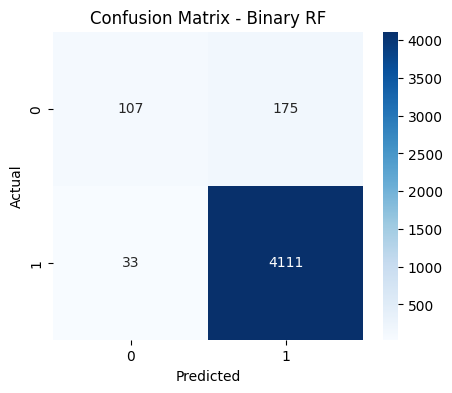

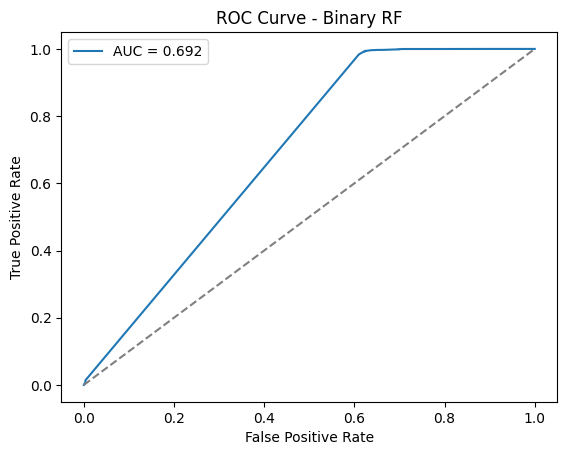

In [114]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(bin_Y_test, bin_Y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Binary RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(bin_Y_test, bin_Y_proba)
auc_score = roc_auc_score(bin_Y_test, bin_Y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Binary RF")
plt.legend()
plt.show()

## Random Forest - Continuous Features 

### Test Train Split + Scaling + PCA 

In [115]:
cont_X = cont_df.drop(['sha256','type'], axis=1)
cont_Y = cont_df['type'].apply(lambda v: 0 if v == 0 else 1)

# Train / Val / Test split
cont_X_trainval, cont_X_test, cont_Y_trainval, cont_Y_test = train_test_split(
    cont_X, cont_Y, test_size=0.15, random_state=42, stratify=cont_Y
)
val_fraction = 0.15 / 0.85
cont_X_train, cont_X_val, cont_Y_train, cont_Y_val = train_test_split(
    cont_X_trainval, cont_Y_trainval, test_size=val_fraction, random_state=42, stratify=cont_Y_trainval
)

#scaling + PCA
scaler_cont = StandardScaler()
cont_X_train_scaled = scaler_cont.fit_transform(cont_X_train)
cont_X_val_scaled   = scaler_cont.transform(cont_X_val)
cont_X_test_scaled  = scaler_cont.transform(cont_X_test)

from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
cont_X_train_pca = pca.fit_transform(cont_X_train_scaled)
cont_X_val_pca   = pca.transform(cont_X_val_scaled)
cont_X_test_pca  = pca.transform(cont_X_test_scaled)

### Training 

In [116]:
rf_cont = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_cont.fit(cont_X_train_pca, cont_Y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=42)

### Prediction and Metrics

In [117]:
cont_Y_pred = rf_cont.predict(cont_X_test_pca)
cont_Y_proba = rf_cont.predict_proba(cont_X_test_pca)[:,1]

print("Continuous Feature Random Forest")
print("Accuracy:", accuracy_score(cont_Y_test, cont_Y_pred))
print(classification_report(cont_Y_test, cont_Y_pred, zero_division=0))

Continuous Feature Random Forest
Accuracy: 0.987353206865402
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       282
           1       0.99      1.00      0.99      4146

    accuracy                           0.99      4428
   macro avg       0.98      0.92      0.94      4428
weighted avg       0.99      0.99      0.99      4428



### Confusion Matrix and ROC 

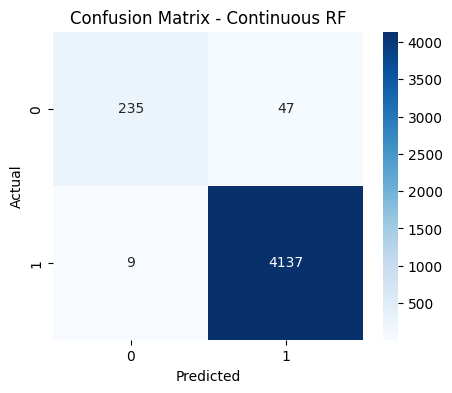

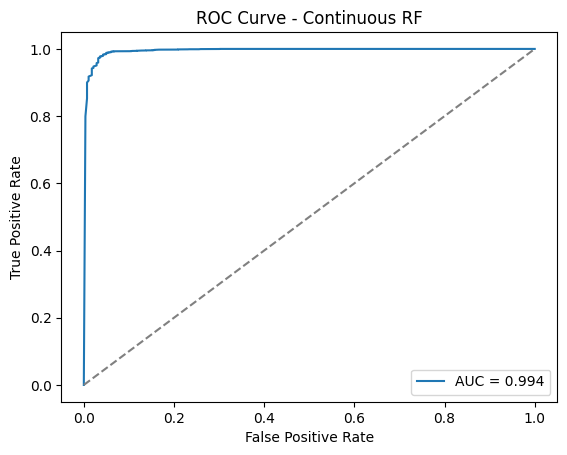

In [118]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(cont_Y_test, cont_Y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Continuous RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(cont_Y_test, cont_Y_proba)
auc_score = roc_auc_score(cont_Y_test, cont_Y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Continuous RF")
plt.legend()
plt.show()